In [1]:
import pandas as pd
import numpy as np
from floodlight.vis.pitches import plot_handball_pitch
from floodlight.core.xy import XY
from floodlight.core.pitch import Pitch
from floodlight.vis.positions import plot_positions
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import pickle
import lightgbm
np.random.seed(31415)
shap.initjs()
import logging
logging.getLogger('shap').setLevel(logging.WARNING) # turns off the "shap INFO" logs
logging.getLogger('matplotlib').setLevel(logging.WARNING)
import warnings
warnings.filterwarnings('ignore')

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [2]:
# import Shotlist with xG Values and Game list
detailed_shots = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/detailed_shots_dataset_result.csv')
simple_shots = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/simple_shots_dataset_result.csv')
game_list_df = pd.read_csv('{path}{filename}'.format(path='/work/users/ca439qyki/R/Kinexon/Data/Goals/', filename='game_list.csv'))
player_ids = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/players_sensors_map.csv', usecols=[1,2,3,4,5])

# Get games for Leipzig and Bergischer HC
teams = ['SC DHFK Leipzig','Bergischer HC']
game_list_df = game_list_df[game_list_df['home_team'].isin(teams) & game_list_df['away_team'].isin(teams)]

## Set import paths for the kiexon data per game
kinexon_inertial_path = '/work/users/ca439qyki/R/Kinexon/Data/RAW/{short}/Saison_{season}/Spieltag/{gameday_number:02d}/{team_name_home}_vs._{team_name_away}_Match_inertial.csv'
kinexon_positions_path = '/work/users/ca439qyki/R/Kinexon/Data/RAW/{short}/Saison_{season}/Spieltag/{gameday_number:02d}/{team_name_home}_vs._{team_name_away}_Match_positions.csv'

In [3]:
## Load simple Model inclusive Calibrateion Model
simple_model = pickle.load(open('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/simple/T_test_xgboost.sav', 'rb'))
simple_feature_names = ["distance","visible_angle", "angle_to_mid"]

In [4]:
detailed_model = pickle.load(open('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Models/detailed/T_test_lightgbm.sav', 'rb'))

detailed_feature_names = ["distance","visible_angle", "angle_to_mid", "time_between_shots_s", "dist_closest_def","shooter_goalkeeper_dist", "shot_goalkeeper_dist",
                        "shooter_goalkeeper_angle", "shot_goalkeeper_angle","player_speed", "number_of_passes", "ball_posession","pressur_index", "players_in_shot_angle_from_shot",
                        "players_in_shot_angle_from_player", "powerplay", "empty_net"]

In [5]:
explainer = shap.TreeExplainer(simple_model.named_steps['classifier'])
X_pre = pd.DataFrame(simple_model.named_steps['preprocessor'].transform(simple_shots), columns=simple_feature_names)
shap_values = explainer.shap_values(X_pre)

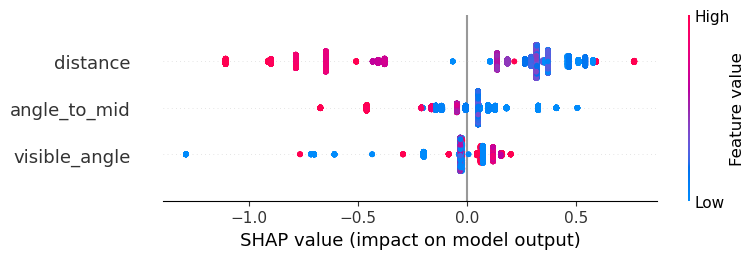

In [6]:
shap.summary_plot(shap_values,X_pre[simple_feature_names], show=False)
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/simple/T__shap_sum_bee_XGBoost.png")

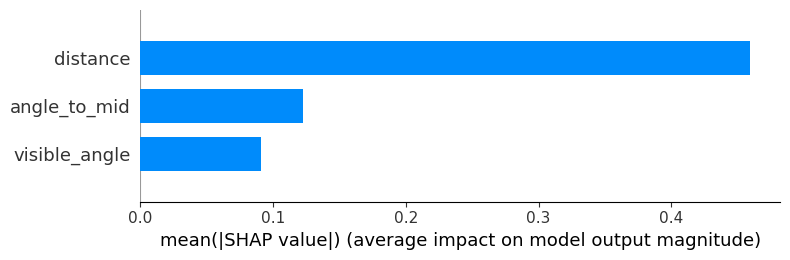

In [7]:
shap.summary_plot(shap_values,X_pre[simple_feature_names], class_names=['No Goal', 'Goal'],show=False, plot_type="bar")
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/simple/T__shap_sum_XGBoost.png")

In [8]:
explainer = shap.TreeExplainer(detailed_model.named_steps['classifier'])
X_pre = pd.DataFrame(detailed_model.named_steps['preprocessor'].transform(detailed_shots), columns=detailed_feature_names)
shap_values = explainer.shap_values(X_pre)

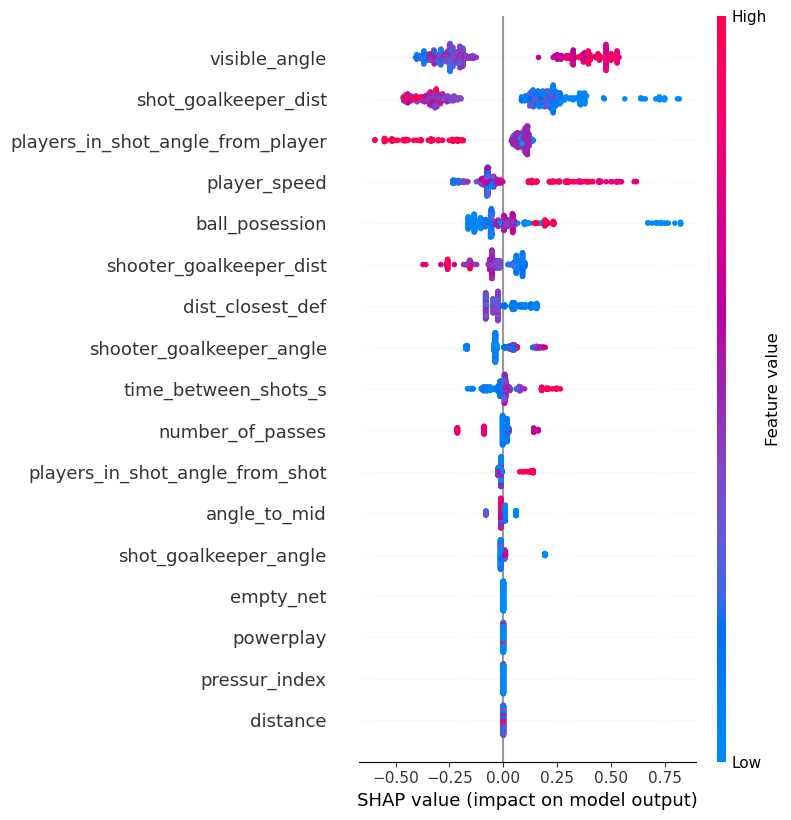

In [9]:
shap.summary_plot(shap_values[1],X_pre[detailed_feature_names], show=False)
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/detailed/T__shap_sum_bee_lightgbm.png")

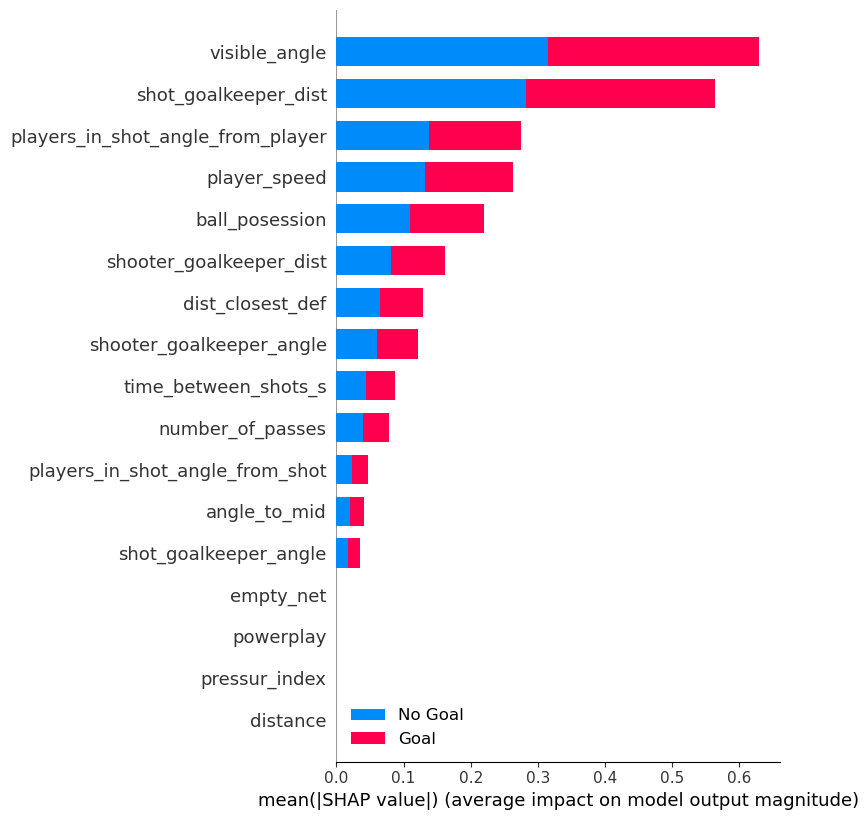

In [10]:
shap.summary_plot(shap_values,X_pre[detailed_feature_names], class_names=['No Goal', 'Goal'], show=False)
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/detailed/T__shap_sum_lightgbm.png")

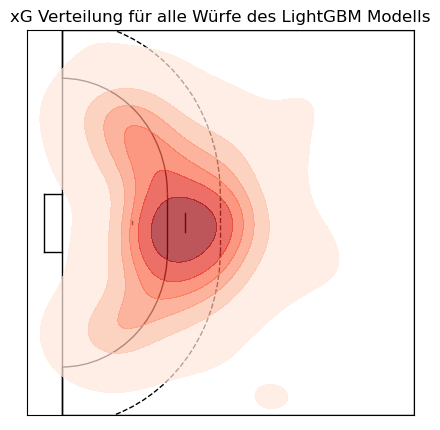

In [20]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
# plt.contourf(detailed_shots['norm_x_shot'],detailed_shots['norm_y_shot'], detailed_shots['lightgbm_xG'],alpha=.85,cmap='OrRd',levels=50)
ax = sns.kdeplot(data=detailed_shots, x='norm_x_shot',y ='norm_y_shot', weights='lightgbm_xG',cmap="Reds",common_norm=True, cbar=False, ax=ax,fill=True, alpha=.7,
            cbar_kws={'label': 'xG'}, levels = 7)
ax.set_title('xG Verteilung für alle Würfe des LightGBM Modells')
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/kde_LightGBM.png")

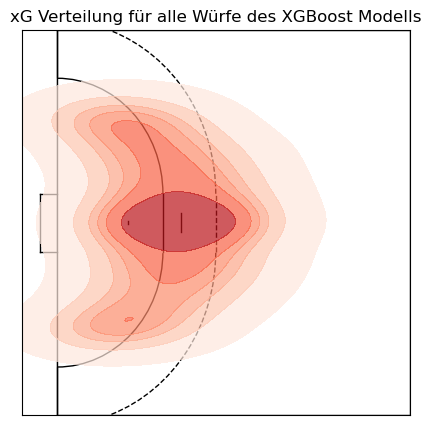

In [21]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
sns.kdeplot(data=simple_shots, x='norm_x_shot',y ='norm_y_shot', weights='xgboost_xG', cmap="Reds", cbar=False, ax=ax,fill=True, alpha=.7,
            cbar_kws={'label': 'xG'}, levels=7)
ax.set_title('xG Verteilung für alle Würfe des XGBoost Modells')
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/kde_XGBoost.png")

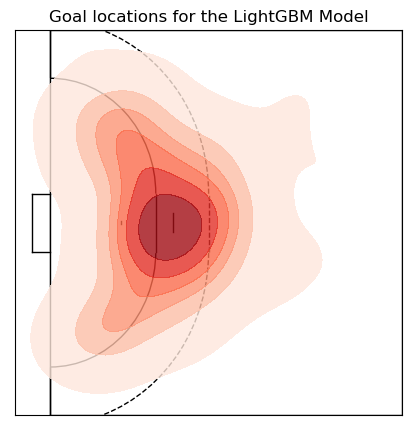

In [12]:
## kde plot
detailed_shots_suc = detailed_shots[detailed_shots['success'] == 1]
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
sns.kdeplot(data=detailed_shots_suc, x='norm_x_shot',y ='norm_y_shot', cbar=False, cmap="Reds",ax=ax,fill=True, alpha=.8,
            cbar_kws={'label': 'Goals'},levels = 7)
ax.set_title('Goal locations for the LightGBM Model')
plt.show()

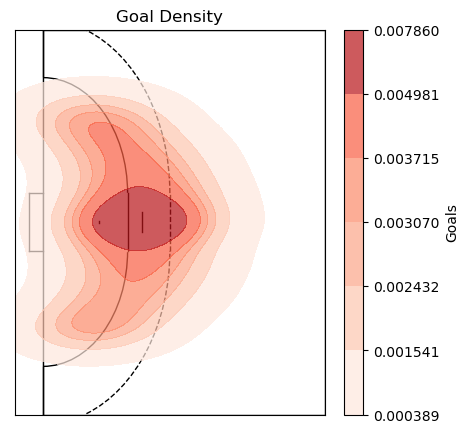

In [14]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
# plt.hexbin(data=simple_shots[simple_shots['success']==1], x='norm_x_shot', y='norm_y_shot',cmap='OrRd',alpha=.7, gridsize=(20,8))
# plt.colorbar()
sns.kdeplot(data=simple_shots[simple_shots['success']==1], x='norm_x_shot',y ='norm_y_shot',cbar=True,cmap="Reds", ax=ax,fill=True, alpha=.7,
            cbar_kws={'label': 'Goals'}, levels=7)

ax.set_title('Goal Density')
plt.show()

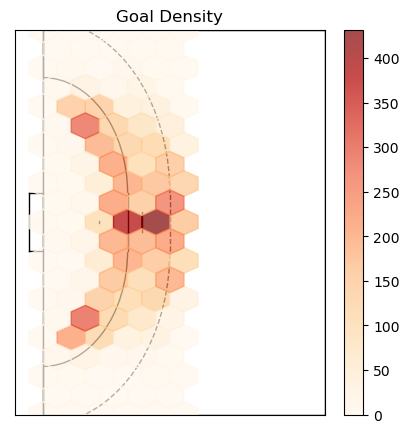

In [15]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
plt.hexbin(data=simple_shots, x='norm_x_shot', y='norm_y_shot',cmap='OrRd',alpha=.7,gridsize=(5,10), extent=(-20,-10,-10,10))
plt.colorbar()
ax.set_title('Goal Density')
plt.show()

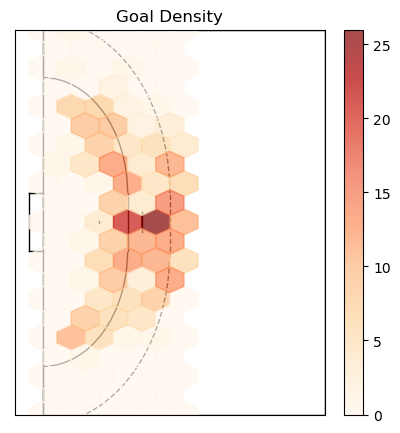

In [17]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
plt.hexbin(data=detailed_shots, x='norm_x_shot', y='norm_y_shot',cmap='OrRd',alpha=.7, 
           gridsize=(5,10), extent=(-20,-10,-10,10))
plt.colorbar()
ax.set_title('Goal Density')
plt.show()

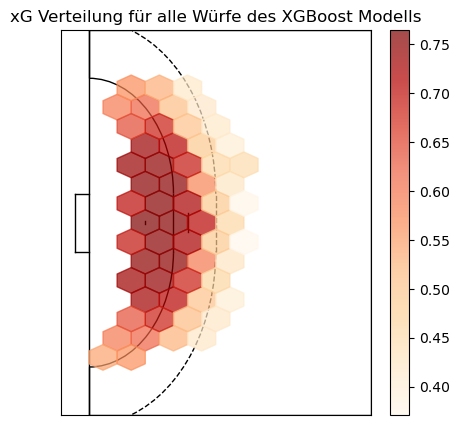

In [9]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
plt.hexbin(data=simple_shots, x='norm_x_shot', y='norm_y_shot',C=simple_shots['xgboost_xG'],reduce_C_function=np.mean,cmap='OrRd',alpha=.7, 
           gridsize=(10,10), extent=(-20,0,-10,10),mincnt=10)
plt.colorbar()
ax.set_title('xG Verteilung für alle Würfe des XGBoost Modells')
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/kde_XGBoost.png")

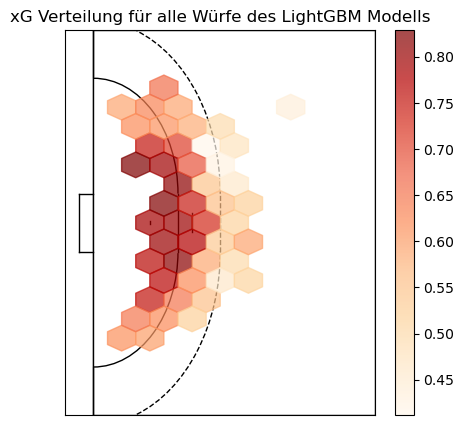

In [11]:
## kde plot
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
plt.hexbin(data=detailed_shots, x='norm_x_shot', y='norm_y_shot',C=detailed_shots['lightgbm_xG'],reduce_C_function=np.mean,cmap='OrRd',alpha=.7, 
           gridsize=(10,10), extent=(-20,0,-10,10), mincnt=1)
plt.colorbar()
ax.set_title('xG Verteilung für alle Würfe des LightGBM Modells')
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/kde_LightGBM.png")

In [19]:
xg_by_player = detailed_shots[detailed_shots['match_id'] == 28449996]
xg_by_player['shots'] = 1
xg_by_player = xg_by_player.groupby('league_id').sum().sort_values('success', ascending=False)
xg_by_player['diff_xG'] = xg_by_player['success'] - xg_by_player['lightgbm_xG']
xg_by_player['diff_xG_baseline'] = xg_by_player['success'] - xg_by_player['xgboost_xG_baseline']
xg_by_player = pd.merge(xg_by_player, player_ids[['league_id', 'name']], how='left', on='league_id')
display(xg_by_player[['name','shots','success','lightgbm_xG', 'xgboost_xG_baseline','diff_xG', 'diff_xG_baseline']])
display(xg_by_player['diff_xG'].min())
display(xg_by_player['diff_xG'].max())

,name,shots,success,lightgbm_xG,xgboost_xG_baseline,diff_xG,diff_xG_baseline
0,Linus Arnesson,10,7,6.244973,7.189576,0.755027,-0.189576
1,Fabian Gutbrod,9,5,4.378882,4.206516,0.621118,0.793484
2,Tom Kare Nikolaisen,5,4,4.038283,3.777193,-0.038283,0.222807
3,Patrick Wiesmach Larsen,6,4,4.054597,4.243310,-0.054597,-0.243310
4,Luca Witzke,7,4,4.000139,4.123050,-0.000139,-0.123050
5,Sebastian Damm,4,4,2.864419,2.554364,1.135581,1.445636
6,Arnor Thor Gunnarsson,3,3,2.152070,1.706445,0.847930,1.293555
7,Maciej Gebala,3,3,2.530465,2.276139,0.469535,0.723861
8,Tom Bergner,3,2,2.497008,2.270469,-0.497008,-0.270469
9,Lovro Jotić,6,2,2.982747,2.989444,-0.982747,-0.989444


-1.526592933751507

1.1355806829542967

In [20]:
xg_by_team = detailed_shots[detailed_shots['match_id'] == 28449996]
xg_by_team['shots'] = 1
xg_by_team = xg_by_team.groupby('team').sum().sort_values('success', ascending=False)
xg_by_team['diff_xG'] = xg_by_team['success'] - xg_by_team['lightgbm_xG']
xg_by_team['diff_xG_baseline'] = xg_by_team['success'] - xg_by_team['xgboost_xG_baseline']
# xg_by_player = pd.merge(xg_by_player, player_ids[['league_id', 'name']], how='left', on='league_id')
display(xg_by_team[['shots','success','lightgbm_xG', 'xgboost_xG_baseline','diff_xG', 'diff_xG_baseline']])
display(xg_by_team['diff_xG'].min())
display(xg_by_team['diff_xG'].max())

,shots,success,lightgbm_xG,xgboost_xG_baseline,diff_xG,diff_xG_baseline
team,,,,,,
Bergischer HC,46,30,29.787024,28.779121,0.212976,1.220879
SC DHFK Leipzig,44,20,25.654455,26.776360,-5.654455,-6.776360


-5.654455243162751

0.21297586773989607

In [21]:
shap_xg_by_play = detailed_shots[(detailed_shots['lightgbm_xG'] == detailed_shots['lightgbm_xG'].max()) |
                             (detailed_shots['lightgbm_xG'] == detailed_shots['lightgbm_xG'].min()) |
                             ((detailed_shots['lightgbm_xG'] >= 0.81) & (detailed_shots['success']==0)) |
                             ((detailed_shots['lightgbm_xG'] <= 0.29) & (detailed_shots['success']==1))]

display(shap_xg_by_play[['success', 'xgboost_xG_baseline', 'lightgbm_xG','match_id']])

,success,xgboost_xG_baseline,lightgbm_xG,match_id
2,1,0.787218,0.909647,18949282.0
13,1,0.534945,0.281689,18949282.0
234,0,0.529078,0.196533,27373216.0
389,0,0.744640,0.818347,28450398.0


In [22]:
def shap_force(clf, X, feature_names,simple=False):
    explainer = shap.TreeExplainer(clf.named_steps['classifier'])
    X_pre = pd.DataFrame(clf.named_steps['preprocessor'].transform(X), columns=feature_names)
    shap_values = explainer.shap_values(X_pre)
    if simple:
        ## Plot the prediction's explanation
        return shap.force_plot(explainer.expected_value,
                                  shap_values=shap_values,
                                  features=X_pre[feature_names],out_names='xG output value')        
    else:
        ## Plot the prediction's explanation
        return shap.force_plot(explainer.expected_value[1],
                                  shap_values=shap_values[1],
                                  features=X_pre[feature_names],out_names='xG output value')

In [23]:
for i in range(len(shap_xg_by_play)):
    instance = shap_xg_by_play.iloc[[i]]
    display(shap_force(simple_model, instance, simple_feature_names, simple=True))

In [24]:
# for ind in shap_xg_by_play.index:
for i in range(len(shap_xg_by_play)):
    instance = shap_xg_by_play.iloc[[i]]
    display(shap_force(detailed_model, instance, detailed_feature_names))
# plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/detailed/force1.png")

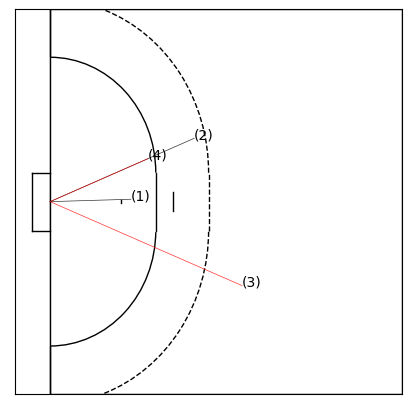

In [25]:
fig=plt.figure() #set up the figures
fig.set_size_inches(5, 5)
ax=fig.add_subplot(1,1,1)
ax=plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
plt.ylim(-10, 10)
plt.xlim(-22, 0)
i = 1
for index, row in shap_xg_by_play.iterrows():
    if i != 6:
        xy_pos = np.array([row['norm_x_shot'], -row['norm_y_shot']])
        # plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0)
        if row['success'] == 1:
            color="Black"
        else:
            color="Red"
        ax.text(row['norm_x_shot'], -row['norm_y_shot'], "({})".format(i))
        ax.plot([row['norm_x_shot'], -20],  [-row['norm_y_shot'],0], linewidth=0.5, color=color,zorder=0, alpha = 0.8)
        i += 1
# plt.show()
plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/CaseStudy.png")

In [26]:
# plot handball pitch
def plot_positions_on_pitch(home_data, away_data, shot_event, shooter_snapshot, idx, home_team, away_team, lgbm_xG, rf_xG,i):
    if home_team == 'SC DHFK Leipzig':
        colors = ['green', 'blue']
    else:
        colors = ['blue', 'green']
    events = [[home_team], [away_team], ['Ball'], ['Kinexon Ball']]
    sign = -1
    if idx in [13,45,333,389]:
        sign = 1
    #plot player and ball positions on the pitch
    ax = plt.subplots(figsize=(10, 5))[1]
    plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
    for color, event in zip(colors, events):
        alphas = [1]
        if color == 'blue':
            x_list = list(sign*home_data.loc[home_data['group name'] != 'Ball']['x in m'])
            y_list = list(sign*home_data.loc[home_data['group name'] != 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'yellow':
            x_list = list(sign*home_data.loc[home_data['group name'] == 'Ball']['x in m'])
            y_list = list(sign*home_data.loc[home_data['group name'] == 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'green':
            x_list = list(sign*away_data['x in m'])
            y_list = list(sign*away_data['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'red':
            x_list = [shot_event['norm_x_shot']]
            y_list = [-shot_event['norm_y_shot']]

        xy_pos = np.array([[coord for coords in zip(x_list, y_list) for coord in coords]])
        plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0, color=color, label=event[0], alpha = alphas)

    # plot lines to the goalposts
    ax.plot([sign*shooter_snapshot['x in m'].values[0], -20], [sign*shooter_snapshot['y in m'].values[0],-1.5], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
    ax.plot([sign*shooter_snapshot['x in m'].values[0], -20], [sign*shooter_snapshot['y in m'].values[0],1.5], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
    ax.text(-20, 13, "LightGBM xG: {:5.4f}".format(lgbm_xG), fontsize="large")
    ax.text(-20, 12, "XGBoost xG: {:5.4f}".format(rf_xG), fontsize="large")
    ax.text(-22,13, "({})".format(i),fontsize="large")
    # leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # for l in leg.legendHandles:
    #     l.set_alpha(1)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/Shot_{}.png".format(i), bbox_inches="tight")    
    
def round_to_next_n(x, n=50):
    return int(n * round(float(x)/n))

func_round = np.vectorize(round_to_next_n)

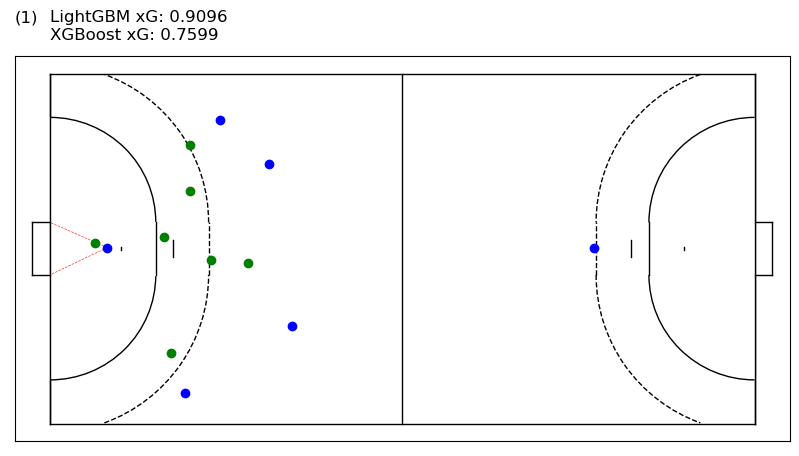

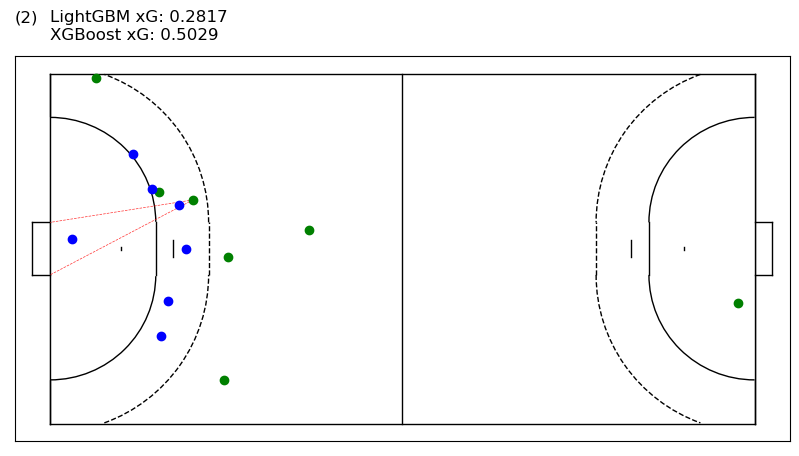

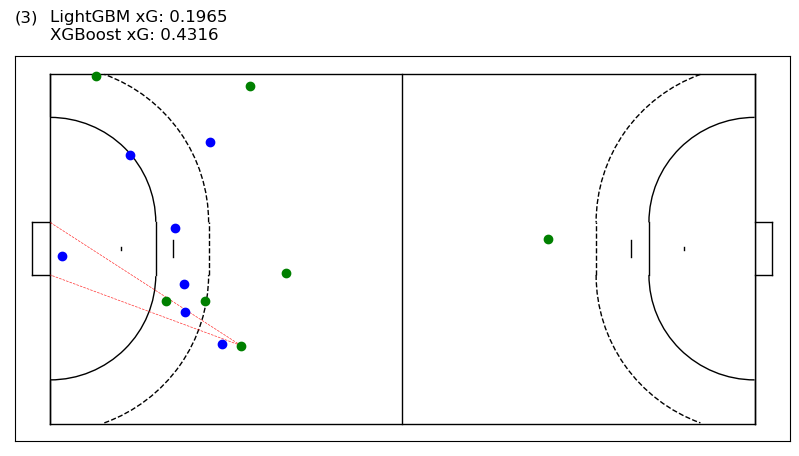

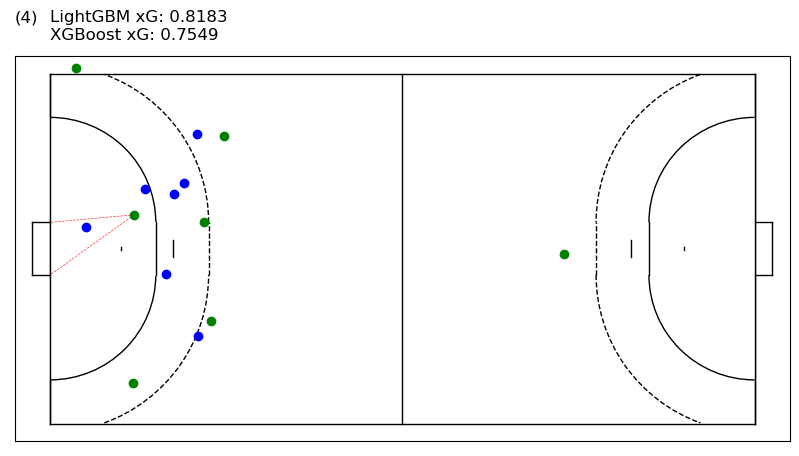

In [27]:
shot_list_df = pd.DataFrame()
i = 1
player_ids = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/players_sensors_map.csv', usecols=[1,2,3,4,5])
goalkeepers = player_ids[player_ids['goalie'] == 1]
# test = game_list_df[game_list_df['match_id']== 28449996]
test = game_list_df
test['shots'] = test['match_id'].apply(lambda x: shap_xg_by_play[shap_xg_by_play['match_id'] == x])
for idx, row in test.iterrows():
    if row['saison'] == '2019_2020':
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leipzig'),'Bergischer HC': ('BHC', 'Bergischer')}
    else:
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leip'),'Bergischer HC': ('BHC', 'Bergischer_HC')}
        
    ## import relevant Kinexon Data for the Game
    home_team = teams_dict.get(row['home_team'])
    away_team = teams_dict.get(row['away_team'])
    home_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    home_pos_df = pd.read_csv(kinexon_positions_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';',usecols=[0,2,3,4,5,8,9,10,11,16])
    away_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    away_pos_df = pd.read_csv(kinexon_positions_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,3,4,5,8,9,10,11,16])
    
    ## merge inertial and pos Dataframes for home and away
    away_inertial_df['merge_time'] = func_round(away_inertial_df['ts in ms'])
    away_pos_df['merge_time'] = away_pos_df['ts in ms']
    home_inertial_df['merge_time'] = func_round(home_inertial_df['ts in ms'])
    home_pos_df['merge_time'] = home_pos_df['ts in ms']
    away_game_data = pd.merge(away_pos_df, away_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    home_game_data = pd.merge(home_pos_df, home_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    
    ## drop Rows where no x and y coordinates are given in the kinexon datasets
    home_game_data = home_game_data.dropna(subset=['x in m', 'y in m'])
    away_game_data = away_game_data.dropna(subset=['x in m', 'y in m'])
    
    ## Create timestamp for Kinexon-Data in ms to compare it with the shots
    home_game_data['merge_time_shots'] = func_round(home_game_data['ts in ms'], n=1000)
    away_game_data['merge_time_shots'] = func_round(away_game_data['ts in ms'], n=1000)
    ## Create features for each shot
    ## reverse sorting of match 18949282 because the last shot is first in the list
    shot_list_game = pd.DataFrame(row['shots'])
    # if (row['match_id'] == 18949282.0):
    #     shot_list_game = shot_list_game.iloc[::-1]
    for idx, shot in shot_list_game.iterrows():
        # display(shot)
        ## Get Kinexon-Data for the timestamp of the shot    
        shot_away_pos = away_game_data[away_game_data['merge_time_shots'] == shot['merge_time_shots']]
        shot_home_pos = home_game_data[home_game_data['merge_time_shots'] == shot['merge_time_shots']]
        player = player_ids.loc[player_ids['league_id'] == shot['league_id']]['player_id'].values
        
        ## Get Shooter and Goalkeeper Data (position, speed...)
        if shot['home']:
            shooter = shot_home_pos[(shot_home_pos['mapped id'] == player.item())]
            goalkeeper = shot_away_pos.loc[shot_away_pos['mapped id'].isin(goalkeepers['player_id'])]
        else:
            shooter = shot_away_pos[(shot_away_pos['mapped id'] == player.item())]
            goalkeeper = shot_home_pos.loc[shot_home_pos['mapped id'].isin(goalkeepers['player_id'])]
            
        ## Some manual captured shots does not math the kinexon data => Shot will be skipped
        if shooter.empty:
            continue

        ## Get snapshot timestamp to get a frozen frame of all player positions
        snapshot_shot_timestamp = shooter['ts in ms'].iloc[-1]
        
        ## Get player positions to the calculated timestamp
        snapshot_home = shot_home_pos[shot_home_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_away = shot_away_pos[shot_away_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_goalkeeper = goalkeeper[goalkeeper['ts in ms'] == snapshot_shot_timestamp]
        snapshot_shooter = shooter[shooter['ts in ms'] == snapshot_shot_timestamp]
        ## plot only snapshot position
        plot_positions_on_pitch(snapshot_home, snapshot_away, shot, snapshot_shooter, idx, row['home_team'],row['away_team'],
                               shot['lightgbm_xG'], shot['random_forest_xG_baseline'],i)
        ##plot position of the last 1 second
        # plot_positions_on_pitch(shot_home_pos, shot_away_pos, shot, snapshot_shooter, idx,row['home_team'],row['away_team']
        i+= 1

In [28]:
powerplay = detailed_shots[detailed_shots['powerplay']==True]
emptynet = detailed_shots[detailed_shots['empty_net']==True]
shot_test = pd.concat([emptynet.iloc[[0]], powerplay.iloc[[0]]])
display(shot_test)

,Unnamed: 0.1,Unnamed: 0,player_id,success,distance,speed_ball,id,league_id,team,match_id,...,number_of_passes,ball_posession,lightgbm_xG_baseline,xgboost_xG_baseline,logistic_reg_xG_baseline,random_forest_xG_baseline,lightgbm_xG,xgboost_xG,logistic_reg_xG,random_forest_xG
54,55,1386,155,1,12.228789,22.870537,424936,1290380.0,SC DHFK Leipzig,18949282.0,...,2.0,5.45,0.702483,0.529078,0.575431,0.558514,0.811878,0.829900,0.999992,0.676245
1,1,1300,252,1,7.232066,30.055923,428080,124183.0,Bergischer HC,18949282.0,...,3.0,7.50,0.594457,0.639378,0.609110,0.624480,0.707086,0.673922,0.589158,0.654224


In [29]:
# plot handball pitch
def plot_positions_on_pitch_powerplay(home_data, away_data, shot_event, shooter_snapshot, idx, home_team, away_team, lgbm_xG, rf_xG,i):
    if home_team == 'SC DHFK Leipzig':
        colors = ['green', 'blue']
    else:
        colors = ['blue', 'green']
    events = [[home_team], [away_team], ['Ball'], ['Kinexon Ball']]
    sign = -1
    if idx in [1,54,13,45,333,389]:
        sign = 1
    #plot player and ball positions on the pitch
    ax = plt.subplots(figsize=(10, 5))[1]
    plot_handball_pitch(xlim=(-20,20), ylim=(-10,10), unit='m', color_scheme='bw',show_axis_ticks=False, ax=ax)
    for color, event in zip(colors, events):
        alphas = [1]
        if color == 'blue':
            x_list = list(sign*home_data.loc[home_data['group name'] != 'Ball']['x in m'])
            y_list = list(sign*home_data.loc[home_data['group name'] != 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'yellow':
            x_list = list(sign*home_data.loc[home_data['group name'] == 'Ball']['x in m'])
            y_list = list(sign*home_data.loc[home_data['group name'] == 'Ball']['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'green':
            x_list = list(sign*away_data['x in m'])
            y_list = list(sign*away_data['y in m'])
            if len(x_list) > 20:
                alphas = [x/len(x_list)*0.5 for x in range(1,len(x_list))]
        if color == 'red':
            x_list = [shot_event['norm_x_shot']]
            y_list = [-shot_event['norm_y_shot']]

        xy_pos = np.array([[coord for coords in zip(x_list, y_list) for coord in coords]])
        plot_positions(xy=XY(xy_pos), ball=False, ax=ax, frame=0, color=color, label=event[0], alpha = alphas)

    # plot lines to the goalposts
    ax.plot([sign*shooter_snapshot['x in m'].values[0], -20], [sign*shooter_snapshot['y in m'].values[0],-1.5], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
    ax.plot([sign*shooter_snapshot['x in m'].values[0], -20], [sign*shooter_snapshot['y in m'].values[0],1.5], linewidth=0.5, color="Red",zorder=0, alpha = 0.8, linestyle = '--')
    # ax.text(-20, 13, "LightGBM xG: {:5.4f}".format(lgbm_xG), fontsize="large")
    # ax.text(-20, 12, "XGBoost xG: {:5.4f}".format(rf_xG), fontsize="large")
    # ax.text(-22,13, "({})".format(i),fontsize="large")
    # leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    # for l in leg.legendHandles:
    #     l.set_alpha(1)
    # plt.show()
    plt.savefig("/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Pictures/Powerplay_EmptyNet_Shot_{}.png".format(i), bbox_inches="tight")    
    
def round_to_next_n(x, n=50):
    return int(n * round(float(x)/n))

Unnamed: 0.1                                      55
Unnamed: 0                                      1386
player_id                                        155
success                                            1
distance                                   12.228789
speed_ball                                 22.870537
id                                            424936
league_id                                  1290380.0
team                                 SC DHFK Leipzig
match_id                                  18949282.0
merge_time_shots                       1569519103000
halftime                                       False
home                                            True
norm_x_shot                                -7.863678
norm_y_shot                                -1.500992
visible_angle                               0.242329
angle_to_mid                                0.123053
time_between_shots_s                            87.0
pressur_index                                 

Unnamed: 0.1                                     1
Unnamed: 0                                    1300
player_id                                      252
success                                          1
distance                                  7.232066
speed_ball                               30.055923
id                                          428080
league_id                                 124183.0
team                                 Bergischer HC
match_id                                18949282.0
merge_time_shots                     1569523525000
halftime                                      True
home                                         False
norm_x_shot                             -15.896817
norm_y_shot                                5.95539
visible_angle                             0.241146
angle_to_mid                                0.9675
time_between_shots_s                          69.0
pressur_index                                  1.0
dist_closest_def               

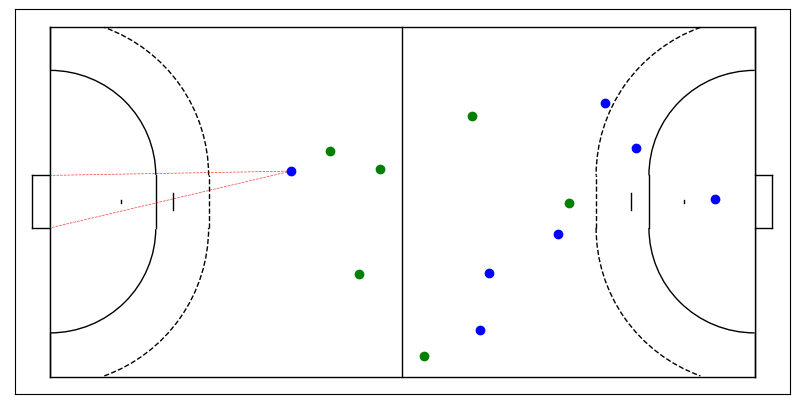

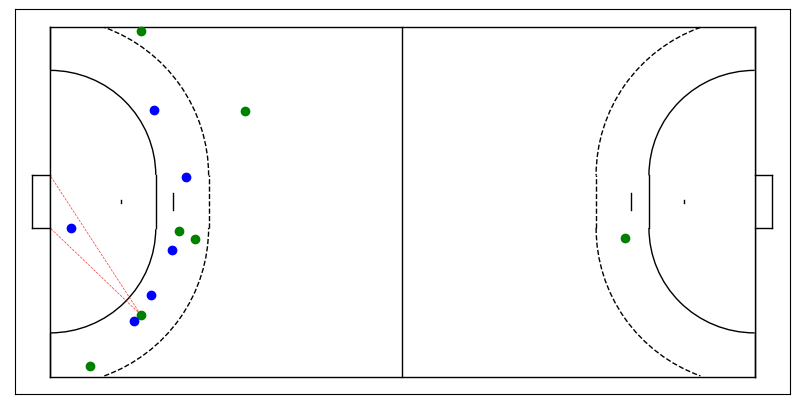

In [30]:
shot_list_df = pd.DataFrame()
i = 1
player_ids = pd.read_csv('/home/sc.uni-leipzig.de/az091jwou/expected_goals_handball/Data/players_sensors_map.csv', usecols=[1,2,3,4,5])
goalkeepers = player_ids[player_ids['goalie'] == 1]
# test = game_list_df[game_list_df['match_id']== 28449996]
test = game_list_df 

test['shots'] = test['match_id'].apply(lambda x: shot_test[shot_test['match_id'] == x])
for idx, row in test.iterrows():
    if row['saison'] == '2019_2020':
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leipzig'),'Bergischer HC': ('BHC', 'Bergischer')}
    else:
        teams_dict = {'SC DHFK Leipzig':('DHFK', 'SC_DHfK_Leip'),'Bergischer HC': ('BHC', 'Bergischer_HC')}
        
    ## import relevant Kinexon Data for the Game
    home_team = teams_dict.get(row['home_team'])
    away_team = teams_dict.get(row['away_team'])
    home_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    home_pos_df = pd.read_csv(kinexon_positions_path.format(short=home_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';',usecols=[0,2,3,4,5,8,9,10,11,16])
    away_inertial_df = pd.read_csv(kinexon_inertial_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,9,10,11])
    away_pos_df = pd.read_csv(kinexon_positions_path.format(short=away_team[0], season=row['saison'],gameday_number=row['game_day'], team_name_home=home_team[1], team_name_away=away_team[1]), sep=';', usecols=[0,2,3,4,5,8,9,10,11,16])
    
    ## merge inertial and pos Dataframes for home and away
    away_inertial_df['merge_time'] = func_round(away_inertial_df['ts in ms'])
    away_pos_df['merge_time'] = away_pos_df['ts in ms']
    home_inertial_df['merge_time'] = func_round(home_inertial_df['ts in ms'])
    home_pos_df['merge_time'] = home_pos_df['ts in ms']
    away_game_data = pd.merge(away_pos_df, away_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    home_game_data = pd.merge(home_pos_df, home_inertial_df, how='left', on=['merge_time', 'sensor id'], suffixes=(None, '_inertial'))
    
    ## drop Rows where no x and y coordinates are given in the kinexon datasets
    home_game_data = home_game_data.dropna(subset=['x in m', 'y in m'])
    away_game_data = away_game_data.dropna(subset=['x in m', 'y in m'])
    
    ## Create timestamp for Kinexon-Data in ms to compare it with the shots
    home_game_data['merge_time_shots'] = func_round(home_game_data['ts in ms'], n=1000)
    away_game_data['merge_time_shots'] = func_round(away_game_data['ts in ms'], n=1000)
    ## Create features for each shot
    ## reverse sorting of match 18949282 because the last shot is first in the list
    shot_list_game = pd.DataFrame(row['shots'])
    # if (row['match_id'] == 18949282.0):
    #     shot_list_game = shot_list_game.iloc[::-1]
    for idx, shot in shot_list_game.iterrows():
        # display(shot)
        ## Get Kinexon-Data for the timestamp of the shot    
        shot_away_pos = away_game_data[away_game_data['merge_time_shots'] == shot['merge_time_shots']]
        shot_home_pos = home_game_data[home_game_data['merge_time_shots'] == shot['merge_time_shots']]
        player = player_ids.loc[player_ids['league_id'] == shot['league_id']]['player_id'].values
        
        ## Get Shooter and Goalkeeper Data (position, speed...)
        if shot['home']:
            shooter = shot_home_pos[(shot_home_pos['mapped id'] == player.item())]
            goalkeeper = shot_away_pos.loc[shot_away_pos['mapped id'].isin(goalkeepers['player_id'])]
        else:
            shooter = shot_away_pos[(shot_away_pos['mapped id'] == player.item())]
            goalkeeper = shot_home_pos.loc[shot_home_pos['mapped id'].isin(goalkeepers['player_id'])]
            
        ## Some manual captured shots does not math the kinexon data => Shot will be skipped
        if shooter.empty:
            continue

        ## Get snapshot timestamp to get a frozen frame of all player positions
        snapshot_shot_timestamp = shooter['ts in ms'].iloc[-1]
        
        ## Get player positions to the calculated timestamp
        snapshot_home = shot_home_pos[shot_home_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_away = shot_away_pos[shot_away_pos['ts in ms'] == snapshot_shot_timestamp]
        snapshot_goalkeeper = goalkeeper[goalkeeper['ts in ms'] == snapshot_shot_timestamp]
        snapshot_shooter = shooter[shooter['ts in ms'] == snapshot_shot_timestamp]
        ## plot only snapshot position
        plot_positions_on_pitch_powerplay(snapshot_home, snapshot_away, shot, snapshot_shooter, idx, row['home_team'],row['away_team'],
                               shot['lightgbm_xG'], shot['random_forest_xG_baseline'],i)
        ##plot position of the last 1 second
        # plot_positions_on_pitch(shot_home_pos, shot_away_pos, shot, snapshot_shooter, idx,row['home_team'],row['away_team']
        i+= 1
        display(shot)